# Import the packages required

In [45]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.model_selection import train_test_split

# Data import and processing

In [20]:
#Data for training
df_combined=pd.read_excel('/home/kamal/Desktop/CAI-2024/DatasetUsed/combined_without_DAB.xlsx')

# Separate the features and labels
X = df_combined[['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30','C']
].values
y = df_combined[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10']].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Defining and trainig and saving the model

In [21]:
# Define the neural network model
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(31, 64)
        self.fc2 = nn.Linear(64, 64)
        self.output_layer = nn.ModuleList([nn.Linear(64, 1) for _ in range(10)])

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        outputs = [layer(x) for layer in self.output_layer]
        return torch.cat(outputs, dim=1)

# Create the model
model = NeuralNet()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 20  #
batch_size = 32
num_batches = len(X_train) // batch_size

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
for epoch in range(num_epochs):
    for i in range(num_batches):
        # Mini-batch data
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        inputs = X_train[start_idx:end_idx]
        labels = y_train[start_idx:end_idx]


        # Forward pass
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Evaluation
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print(f'Test Loss: {test_loss.item()}')


torch.save(model.state_dict(), "/home/kamal/Desktop/CAI-2024/models/model_new_20.pth")

/home/kamal/Desktop/CAI-2024/CAIvenv/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/20], Loss: 0.21862471103668213
Epoch [2/20], Loss: 0.12715193629264832
Epoch [3/20], Loss: 0.10837478935718536
Epoch [4/20], Loss: 0.11375802755355835
Epoch [5/20], Loss: 0.09141808748245239
Epoch [6/20], Loss: 0.0860246792435646
Epoch [7/20], Loss: 0.08070440590381622
Epoch [8/20], Loss: 0.07692184299230576
Epoch [9/20], Loss: 0.07447082549333572
Epoch [10/20], Loss: 0.07210058718919754
Epoch [11/20], Loss: 0.06982029974460602
Epoch [12/20], Loss: 0.06919857114553452
Epoch [13/20], Loss: 0.06840948760509491
Epoch [14/20], Loss: 0.06703807413578033
Epoch [15/20], Loss: 0.06690024584531784
Epoch [16/20], Loss: 0.06509359925985336
Epoch [17/20], Loss: 0.06390447169542313
Epoch [18/20], Loss: 0.06288173794746399
Epoch [19/20], Loss: 0.06207366660237312
Epoch [20/20], Loss: 0.06032109260559082
Test Loss: 0.10118056833744049


# Loading and testing the saved model

In [89]:
def load_and_test_model():
    # Create an instance of the Neural Network
    model = NeuralNet()

    # Load the saved model
    model.load_state_dict(torch.load("/home/kamal/Desktop/CAI-2024/models/model_5.pth"))

    # Test dataset
    df_DAB = pd.read_excel('/home/kamal/Desktop/CAI-2024/DatasetUsed/DAB.xlsx')

    i=0
    hoursBetweenDeparture=1
    output_list=[] # This list will contain the list of the selected airports represented by 1s and 0s
    for i in range(0, 24, hoursBetweenDeparture):
      # Select the first row of the DataFrame and convert it to a tensor
      first_row = df_DAB.iloc[i, :31].values  # Selecting the first row as a NumPy array
      tensor_first_row = torch.tensor([first_row.tolist()], dtype=torch.float32)
      with torch.no_grad():
          output = model(tensor_first_row)
          output = torch.where(output < 0.5, torch.tensor(0.0), torch.tensor(1.0))  #output
          output_list.append(output.flatten().tolist())
    return output_list

output_list=load_and_test_model()

In [90]:
output_list

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0,

# Analysing the result obtained

Importing the necessary functions and datasets for analysis

In [60]:
df_LookupTable = pd.read_excel('/home/kamal/Desktop/CAI-2024/DatasetUsed/FinalLookupTable.xlsx')
df_Citypair = pd.read_excel('/home/kamal/Desktop/CAI-2024/DatasetUsed/CityPair.xlsx')
#df_Citypair only contain the departure and arrival hour we need to find the duration of the flight

In [61]:
# Calculate TimeOfFlight
df_Citypair['TimeOfFlight'] = df_Citypair.apply(lambda row: (row['Arrival Hour'] - row['Departure Hour'] + 24) if (row['Arrival Hour'] - row['Departure Hour']) < 0 else (row['Arrival Hour'] - row['Departure Hour']), axis=1)

# Dropping the extra unused columns for making dataframe simple
df_flightTime = df_Citypair.drop(["Date","Departure Hour", "Arrival Hour"], axis=1)

In [62]:
# Function for calculating the average time of flight as well as the number of flights between two cities in a dataset
def calculate_average_time_of_flight(flight_data):
    new_df = flight_data.groupby(['Departure', 'Arrival']).agg(
        TimeOfFlight=('TimeOfFlight', 'mean'),
        Count=('TimeOfFlight', 'count')
    ).reset_index()

    new_df = new_df.sort_values(['Departure', 'Count'], ascending=[True, False])

    return new_df


new_dataframe = calculate_average_time_of_flight(df_flightTime)
new_dataframe = new_dataframe.reset_index(drop=True) #Just to reset the index to avoid confusion

In [63]:
#Function to find the top ten departure from the given airport
def unique_arrival_departure_single(df, airport_name):
    """
    This function takes a pandas DataFrame with 'Departure' and 'Arrival' columns, and the name of an airport.
    It returns a list of unique arrival airports for the specified departure airport.
    """
    departure_airports = df[df['Departure'] == airport_name]['Arrival'].unique()[:15] # Used already sorted dataframe and return first 10 unique value
    airports_remove= ['MYNN','CYYZ','SJU','SKBO','MUHA','MPTO','MDSD'] # To remove the international destinations from the list
    departure_airports = departure_airports.tolist()  # Convert NumPy array to list
    for item in airports_remove:
      if item in departure_airports:
        departure_airports.remove(item)
    return list(departure_airports[:10])

unique_arrival_departure_single(new_dataframe,'FLL')

['ATL', 'EWR', 'LGA', 'JFK', 'BWI', 'CLT', 'DCA', 'IAH', 'DFW', 'PHL']

In [64]:
#This function returns the time taken from departure airport to the arrival airports
def get_time_of_flight(departure, arrival_list, flight_data):
    result_data = pd.DataFrame(columns=['Arrival', 'TimeOfFlight'])
    for arrival in arrival_list:
        filtered_data = flight_data[(flight_data['Departure'] == departure) & (flight_data['Arrival'] == arrival)]
        if not filtered_data.empty:
            time_of_flight = filtered_data['TimeOfFlight'].values[0]
            result_data = pd.concat([result_data, pd.DataFrame({'Arrival': [arrival], 'TimeOfFlight': [time_of_flight]})], ignore_index=True)
    return result_data

departure = 'FLL'
arrival_list = unique_arrival_departure_single(new_dataframe,'FLL')

time_of_flights = get_time_of_flight(departure, arrival_list, df_flightTime)
time_of_flights

,Arrival,TimeOfFlight
0,ATL,2
1,EWR,3
2,LGA,2
3,JFK,2
4,BWI,3
5,CLT,2
6,DCA,3
7,IAH,2
8,DFW,2
9,PHL,2


In [65]:
#This is the function to return the time duration for the flights between the city pairs
def get_time_duration(airports,departure):
    time_of_flights = get_time_of_flight(departure, airports, df_flightTime)
    # Filter the DataFrame to include only rows with the specified airports
    airport_df = time_of_flights[time_of_flights['Arrival'].isin(airports)]

    # Return the list of TimeOfFlight values
    return airport_df['TimeOfFlight'].tolist()

airports_pair_DAB=unique_arrival_departure_single(new_dataframe,'FLL')
get_time_duration(airports_pair_DAB,'FLL')

[2, 3, 2, 2, 3, 2, 3, 2, 2, 2]

In [66]:
def get_other_mean_std(hour, airports):
    # Filter the DataFrame to include only rows with the given hour and specified airports
    airport_hour_df = df_LookupTable[(df_LookupTable['DATE'].dt.hour == hour) & (df_LookupTable['Airport'].isin(airports))]

    # Group the data by airport and hour, and calculate the mean and standard deviation of the 'Other' column
    group_mean_std = airport_hour_df.groupby(['Airport', airport_hour_df['DATE'].dt.hour])['Other'].agg(['mean', 'std']).reset_index()

    # Return a list of tuples, with each tuple containing airport, mean, and std
    return [(airport, mean, std) for airport, mean, std in zip(group_mean_std['Airport'], group_mean_std['mean'], group_mean_std['std'])]

In [67]:
#Function to generate the list of time of flights of the pair airports
def get_other_mean_std(hours, airports):
    result = []

    # Iterate over each airport and corresponding hour
    for airport, hour in zip(airports, hours):
        # Filter the DataFrame to include only rows with the given hour and specified airport
        airport_hour_df = df_LookupTable[(df_LookupTable['DATE'].dt.hour == hour) & (df_LookupTable['Airport'] == airport)]

        # Group the data by airport and hour, and calculate the mean and standard deviation of the 'Other' column
        group_mean_std = airport_hour_df.groupby(['Airport', airport_hour_df['DATE'].dt.hour])['Other'].agg(['mean', 'std']).reset_index()

        # Append the airport, mean, and std to the result list
        result.extend([(airport, mean, std) for airport, mean, std in zip(group_mean_std['Airport'], group_mean_std['mean'], group_mean_std['std'])])

    # Return the result list
    return result

In [72]:
#Function to print the capability of airport at particular hour of the day
def capability_mean_std(airport, hour):
    # Filter the DataFrame to include only rows with the given airport and hour
    airport_hour_df = df_LookupTable[(df_LookupTable['Airport'] == airport) & (df_LookupTable['DATE'].dt.hour == hour)]

    # Check if there is data available
    if airport_hour_df.empty:
        print("No data available for the given airport and hour.")
        return

    # Calculate the mean and standard deviation of the 'Other' column
    mean = airport_hour_df['Other'].mean()
    std = airport_hour_df['Other'].std()

    return mean,std

In [85]:
def CapabilityForWholeDayGA(hour_departure,departure_airport,airport_pair):
  time_flight = get_time_duration(airport_pair,departure_airport) # Finding the duration of flight in hours
  hours_arrival=[x+hour_departure for x in time_flight] # Finding the arrival time in the airports
  hours_arrival_final = [num % 24 for num in hours_arrival] #Changing the arrival time into suitable format

  meanDeparture,stdDeparture= capability_mean_std(departure_airport, hour_departure)
  meanRoundoff=round(meanDeparture)
  if meanRoundoff==0:
    meanRoundoff=1


  # Call the function with the hours and airports lists
  result = get_other_mean_std(hours_arrival_final, airport_pair)
  return result,meanRoundoff

In [87]:
departure_airport='DAB'
top_ten_airports_pair=unique_arrival_departure_single(new_dataframe,departure_airport)
#print(top_ten_airports_pair)
hoursBetweenDeparture=1
result_list=[]
meanCapability_list=[]
reward_list=[]
best_combination_list=[]
for hour in range(0, 24, hoursBetweenDeparture):
    result, meanCapability = CapabilityForWholeDayGA(hour, departure_airport, top_ten_airports_pair)
    result_list.append(result)
    meanCapability_list.append(meanCapability)

In [77]:
# Min-max normalization function
def min_max_normalize(tensor):
    min_value = tensor.min()
    max_value = tensor.max()
    return (tensor - min_value) / (max_value - min_value)

# Function to calculate the reward
def calculate_fs(selection_vector,result,meanCapability):
    # Convert the result list to tensors for easy manipulation
    popularity = torch.tensor([10,9,8,7,6,5,4,3,2,1])
    capability = torch.tensor([airport[1] for airport in result])
    standard_deviation = torch.tensor([airport[2] for airport in result])

    # Min-max normalize the tensors
    popularity = min_max_normalize(popularity)
    capability = min_max_normalize(capability)
    standard_deviation = min_max_normalize(standard_deviation)

    selected_airports_capability = torch.sum(capability * selection_vector)
    selected_airports_std_dev = torch.sum(standard_deviation * selection_vector)

    #Penalty on the basis of total number of flights
    rounded_capabilities = []
    for item in result:
      capability = item[1]
      rounded_capability = round(capability)  # Round off to the nearest integer
      if rounded_capability == 0:
          rounded_capability = 1  # Replace zero with 1
      rounded_capabilities.append(rounded_capability)


    totalNumberOfFlights = 0

    for flag, element in zip(selection_vector, rounded_capabilities):
          if flag == 1:
            totalNumberOfFlights += element

    penalty= torch.tensor(0.0)

    if totalNumberOfFlights>=meanCapability:
        penalty=torch.tensor(1.0)


    reward = 0.5 * torch.sum(popularity * selection_vector) + 0.2 * selected_airports_capability - 0.3 * selected_airports_std_dev - penalty
    return reward

In [91]:
fs_list=[]
for i in range(len(output_list)):
  fs = calculate_fs(torch.tensor(output_list[i]), result_list[i], meanCapability_list[i])
  fs_list.append(fs)
  print(f"{output_list[i]} {fs}")

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0] 0.6212092638015747
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0] 1.0239746570587158
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0] 1.25587797164917
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0] 0.9223430156707764
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0] 1.0329489707946777
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0] 1.0470757484436035
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0] 0.9184811115264893
[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.6960614919662476
[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.6933885812759399
[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] 1.793950080871582
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0] 0.756758451461792
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0] 1.6717100143432617
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0] 1.716630220413208
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0] 0.7984466552734375
[1.0, 1.0, 1.0, 1.0, 1.0,

In [92]:
[fs.item() for fs in fs_list]

[0.6212092638015747,
 1.0239746570587158,
 1.25587797164917,
 0.9223430156707764,
 1.0329489707946777,
 1.0470757484436035,
 0.9184811115264893,
 0.6960614919662476,
 0.6933885812759399,
 1.793950080871582,
 0.756758451461792,
 1.6717100143432617,
 1.716630220413208,
 0.7984466552734375,
 0.8116337060928345,
 1.7857338190078735,
 1.887810230255127,
 1.6510260105133057,
 1.7309647798538208,
 1.6627955436706543,
 1.6525728702545166,
 1.7963409423828125,
 0.84832763671875,
 0.9737069606781006]

In [84]:
# This is the fitness score predicted by the various Neural Network model trained under the different number of epochs
# We can obtain this by changing the numbe of epochs and training the model and finally using the model for prediction
# Variou models trained under different number of epochs are in folder models which can be directly used to get the results as well

# Trained for 5 epochs
fs_5=[0.6212092638015747, 1.0239746570587158, 1.25587797164917, 0.9223430156707764, 1.0329489707946777, 1.0470757484436035, 0.9184811115264893, 0.6960614919662476, 0.6933885812759399, 1.793950080871582, 0.756758451461792, 1.6717100143432617, 1.716630220413208, 0.7984466552734375, 0.8116337060928345, 1.7857338190078735, 1.887810230255127, 1.6510260105133057, 1.7309647798538208, 1.6627955436706543, 1.6525728702545166, 1.7963409423828125, 0.84832763671875, 0.9737069606781006]

#Trained for 15 epochs
fs_15=[0.6212092638015747, 1.0239746570587158, 1.25587797164917, 0.9223430156707764, 1.0329489707946777, 1.0470757484436035, 0.7405339479446411, 0.6960614919662476, 0.6933885812759399, 1.793950080871582, 1.7207224369049072, 1.6404964923858643, 1.6500883102416992, 0.6965692043304443, 1.7152032852172852, 1.7126290798187256, 1.712332010269165, 1.6510260105133057, 1.7309647798538208, 1.6627955436706543, 1.6525728702545166, 1.7963409423828125, 1.6198214292526245, 0.7079417705535889]


#Trained for 25 epochs
fs_25=[0.6212092638015747, 1.0239746570587158, 1.25587797164917, 0.9223430156707764, 1.0329489707946777, 1.0470757484436035, 0.6019701957702637, 1.636925458908081, 1.572135090827942, 1.5328603982925415, 1.5234249830245972, 1.4278795719146729, 1.4832966327667236, 1.5651130676269531, 1.556949496269226, 1.5000004768371582, 1.6428711414337158, 1.4874745607376099, 1.5744165182113647, 1.5573570728302002, 1.5555081367492676, 1.6996312141418457, 1.3982652425765991, 0.8155604600906372]



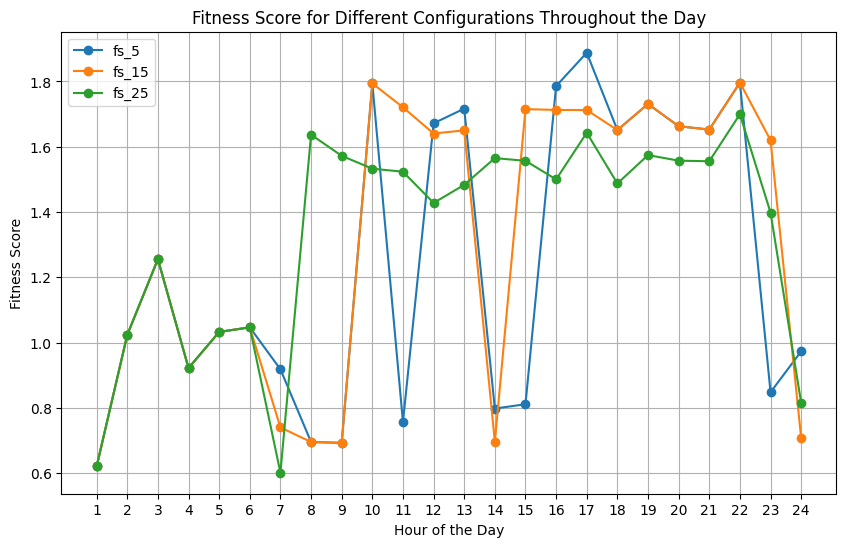

In [83]:
import matplotlib.pyplot as plt
# Define the hours of the day for the x-axis
hours_of_day = list(range(1, 25))

# Plot the rewards
plt.figure(figsize=(10, 6))
plt.plot(hours_of_day, fs_5, label='fs_5', marker='o')
plt.plot(hours_of_day, fs_15, label='fs_15', marker='o')
plt.plot(hours_of_day, fs_25, label='fs_25', marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Fitness Score')
plt.title('Fitness Score for Different Configurations Throughout the Day')
plt.legend()
plt.grid(True)
plt.xticks(hours_of_day)
plt.show()